# Funcions

## plot_predict_result

In [1]:
import matplotlib.pyplot as plt

def plot_predict_result(results, save_path=None):
    plt.figure(figsize=[7, 7])
    
    plt.subplot(2, 2, 1)
    plt.imshow(results['image'])
    plt.title(results['class_name'])
    plt.axis("off")
    
    plt.subplot(2, 2, 2)
    plt.imshow(results['pointed_img'])
    plt.title('pointed_img')
    plt.axis("off")
    
    plt.subplot(2, 2, 3)
    plt.imshow(results['removed_bg_img'])
    plt.title('rembg')
    plt.axis("off")
    
    plt.subplot(2, 2, 4)
    plt.imshow(results['predicted_image'])
    plt.title(results['score'])
    plt.axis("off")

    if save_path is not None:
        plt.savefig(save_path)

    return plt

## test

In [2]:
import torch

from pathlib import Path
import os
from tqdm.auto import tqdm
import time
from PIL import Image
import json

from model.disease_detection import AI_model

def test(
    disease_detector: AI_model,
    test_dataset: list,
    save_result_path: list,
):
    
    test_path = Path(test_dataset)
    
    save_results_root_path = Path(save_result_path)
    save_results_root_path.mkdir(exist_ok=True, parents=True)

    save_results_img_path = save_results_root_path / 'imgs'
    save_results_img_path.mkdir(exist_ok=True, parents=True)
    
    test_results = {
        'preds' : [],
        'targets' : [],
        'scores' : []
    }
    
    for class_name in tqdm(os.listdir(test_path), desc='Class process'):
        for img_name in tqdm(os.listdir(test_path / class_name), desc='---Image predict'):
            img_path = test_path / class_name / img_name
            image = Image.open(img_path)
    
            results = disease_detector._predict(image)
            
            preds = disease_detector.cnn_model.class_name_to_idx[results['class_name']]
            target = disease_detector.cnn_model.class_name_to_idx[class_name]
            score = results['score']
            
            test_results['preds'].append(preds)
            test_results['targets'].append(target)
            test_results['scores'].append(score)
            
            plot_predict_result(results=results, save_path= save_results_img_path / (class_name + '_' + img_name + '.jpg'))
            plt.close()
        torch.cuda.empty_cache()
    
    info_data = {
        'model': disease_detector.cnn_model.model_name,
        "class_names" : disease_detector.cnn_model.class_names,
        "results" : test_results
    }
    
    with open(save_results_root_path / 'info.json', 'w') as f:
        json.dump(info_data, f, indent=4)

    return info_data

## rename_class_idx

In [3]:
def rename_class_idx(df, target):
    def _rename_class_idx(x):
        if x == target:
            return 0
        else: return 1
            
    df['preds'] = df['preds'].apply(_rename_class_idx)
    df['targets'] = df['targets'].apply(_rename_class_idx)

## cal_precision_recall_with_threshold

In [4]:
def cal_precision_recall_with_threshold(df, threshold):
    
    over_threshold = df['scores'] >= threshold
    under_threshold = df['scores'] < threshold
    
    preds_eq_targets = (df['preds'] == df['targets']) & (df['targets'] == 0)
    preds_ueq_targets = (df['preds'] != df['targets']) & (df['targets'] == 0)
    
    targets_ueq_preds = (df['preds'] != df['targets']) & (df['preds'] == 0)
    
    df = (df['preds'] != df['targets']) & (df['preds'] == 0)
    
    TP = len(df[preds_eq_targets & over_threshold])
    FP = len(df[preds_ueq_targets & over_threshold])
    FN = len(df[targets_ueq_preds | under_threshold])

    try:
        precision = TP / (TP + FP)
    except ZeroDivisionError:
        precision = 0

    try:
        recall = TP / (TP + FN)
    except ZeroDivisionError:
        recall = 0
    
    return round(precision, 4), round(recall, 4)

## cal_precision_recall_per_class

In [5]:
from tqdm.auto import tqdm
import numpy as np

def cal_precision_recall_with_threshold_range(df):
    results = {
        'thresholds' : [],
        'precision_scores' : [],
        'recall_scores' : [],
    }
    
    for threshold in tqdm(np.round(np.linspace(0, 100, 10000), 2), desc='--------'):
        threshold /= 100
        precision, recall = cal_precision_recall_with_threshold(df, threshold= threshold)
        
        results['precision_scores'].append(precision)
        results['recall_scores'].append(recall)
        results['thresholds'].append(threshold)

    return results

def cal_precision_recall_per_class(df):   
    results = {}
    
    classes_idx = sorted(df['targets'].unique())
    for class_idx in tqdm(classes_idx, desc='Class'):
        sub_df = df[(df['targets'] == class_idx) | (df['preds'] == class_idx)].copy()
        rename_class_idx(sub_df, class_idx)
        precision_recall_results = cal_precision_recall_with_threshold_range(sub_df)
        results[class_idx] = precision_recall_results
        # break

    return results

## find_best_threshold

In [6]:
import pandas as pd

def find_best_threshold(results):
    def __find_first(arr):
        target = max(arr)
        for i, value in enumerate(arr):
            if value == target: return i
                
    summary = {}
    
    for class_idx, results_per_class in results.items():
    
        max_precision = max(results_per_class['precision_scores'])
        best_threshold = (results_per_class['thresholds'][__find_first(arr=results_per_class['precision_scores'])])
        recall = (results_per_class['recall_scores'][__find_first(arr=results_per_class['precision_scores'])])
    
        summary[class_idx] = {
            'threshold': best_threshold,
            'recall': recall,
            'precision': max_precision,
        }
    df = pd.DataFrame(summary)
    df['Average'] = df.T.apply(lambda column: np.average(column))
    return df

## plot_summary

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_summary(df):
    plt.figure(figsize=(13, 5))
    df_melted = df.T.reset_index().melt('index')
    
    ax = sns.barplot(x='index', y='value', hue='variable', data=df_melted)
    ax.set_ylim(0, 1.5)
    plt.title('Best threshold for Class')
    plt.xlabel('Class')
    plt.ylabel('Score')
    
    
    for i in range(len(df_melted)):
        p = ax.patches[i]
        ax.annotate(format(p.get_height(), '.2f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 10), 
                        textcoords = 'offset points',
                        fontsize = 7)

    return plt

# Overall_tester Class

In [8]:
import torch

from model.utils import plot_confmat
from model.disease_detection import AI_model
import pandas as pd
from pathlib import Path
import json

class Overall_tester:
    def __init__(
        self,
        path_to_model: list,
        test_dataset: list,
        save_result_path: list,
    ):
        
        self.path_to_model = Path(path_to_model)
        self.test_dataset = Path(test_dataset)
        self.save_result_path = Path(save_result_path)

        self.disease_detector = AI_model(path_to_model)

        self.info_data = None
    def test(self):
        self.info_data = test(
            disease_detector= self.disease_detector,
            test_dataset= self.test_dataset,
            save_result_path= self.save_result_path
        )

    def save_model(self):
        model_name = self.info_data['model']
        print(f"[Save] {self.save_result_path / f'{model_name}.pth'}")
        model = self.disease_detector.cnn_model.model
        
        torch.save(obj=model.state_dict(), f=(self.save_result_path / f'{model_name}.pth'))
        
    def load_info_data(self):
        with open(str(self.save_result_path /'info.json'), 'r') as f:
            self.info_data = json.load(f)
            
    def plot_confmat(self):
        if self.info_data is None:
            self.load_info_data()

        class_names = self.info_data['class_names']
        test_results = self.info_data['results']
        plt = plot_confmat(
            class_names= class_names,
            test_results= test_results,
        )
        print(f"[Save] {self.save_result_path / 'confusion_matrix.jpg'}")
        plt.savefig(self.save_result_path / 'confusion_matrix.jpg')
        return plt

    def find_best_threshold(self):
        if self.info_data is None:
            self.load_info_data()

        info_data_df = pd.DataFrame(self.info_data['results'])

        info_data_df['preds'] = info_data_df['preds'].astype(int)
        info_data_df['targets'] = info_data_df['targets'].astype(int)

        results = cal_precision_recall_per_class(info_data_df)

        best_threshold_df = find_best_threshold(results)

        plt = plot_summary(best_threshold_df)
        
        print(f"[Save] {self.save_result_path / 'best_threshold.xlsx'}")
        best_threshold_df.to_excel(self.save_result_path / 'best_threshold.xlsx')

        print(f"[Save] {self.save_result_path / 'best_threshold.jpg'}")
        plt.savefig(self.save_result_path / 'best_threshold.jpg')
        
        return best_threshold_df, plt

# Run

In [9]:
overall_test = Overall_tester(
    path_to_model='./runs/classify/train6',
    test_dataset= './datasets/tomato_rembg/test/',
    save_result_path= './overall_test/test3',
)

In [12]:
overall_test.test()

Class process:   0%|          | 0/10 [00:00<?, ?it/s]

---Image predict:   0%|          | 0/100 [00:00<?, ?it/s]

---Image predict:   0%|          | 0/100 [00:00<?, ?it/s]

---Image predict:   0%|          | 0/100 [00:00<?, ?it/s]

---Image predict:   0%|          | 0/100 [00:00<?, ?it/s]

---Image predict:   0%|          | 0/100 [00:00<?, ?it/s]

---Image predict:   0%|          | 0/100 [00:00<?, ?it/s]

---Image predict:   0%|          | 0/100 [00:00<?, ?it/s]

---Image predict:   0%|          | 0/100 [00:00<?, ?it/s]

---Image predict:   0%|          | 0/100 [00:00<?, ?it/s]

---Image predict:   0%|          | 0/100 [00:00<?, ?it/s]

[Save] overall_test\test3\confusion_matrix.jpg


<module 'matplotlib.pyplot' from 'C:\\Users\\tranq\\miniconda3\\envs\\leaf_project\\Lib\\site-packages\\matplotlib\\pyplot.py'>

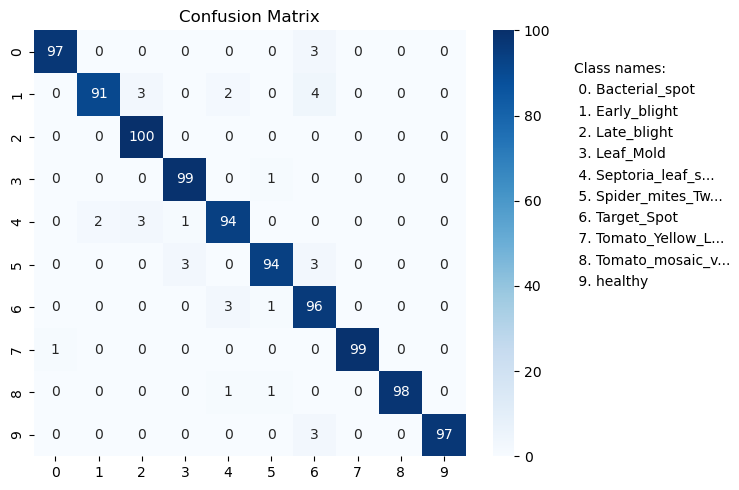

In [13]:
overall_test.plot_confmat()

In [15]:
overall_test.save_model()

[Save] overall_test\test3\effi_net_v2_s.pth


Class:   0%|          | 0/10 [00:00<?, ?it/s]

--------:   0%|          | 0/10000 [00:00<?, ?it/s]

--------:   0%|          | 0/10000 [00:00<?, ?it/s]

--------:   0%|          | 0/10000 [00:00<?, ?it/s]

--------:   0%|          | 0/10000 [00:00<?, ?it/s]

--------:   0%|          | 0/10000 [00:00<?, ?it/s]

--------:   0%|          | 0/10000 [00:00<?, ?it/s]

--------:   0%|          | 0/10000 [00:00<?, ?it/s]

--------:   0%|          | 0/10000 [00:00<?, ?it/s]

--------:   0%|          | 0/10000 [00:00<?, ?it/s]

--------:   0%|          | 0/10000 [00:00<?, ?it/s]

[Save] overall_test\test3\best_threshold.xlsx
[Save] overall_test\test3\best_threshold.jpg


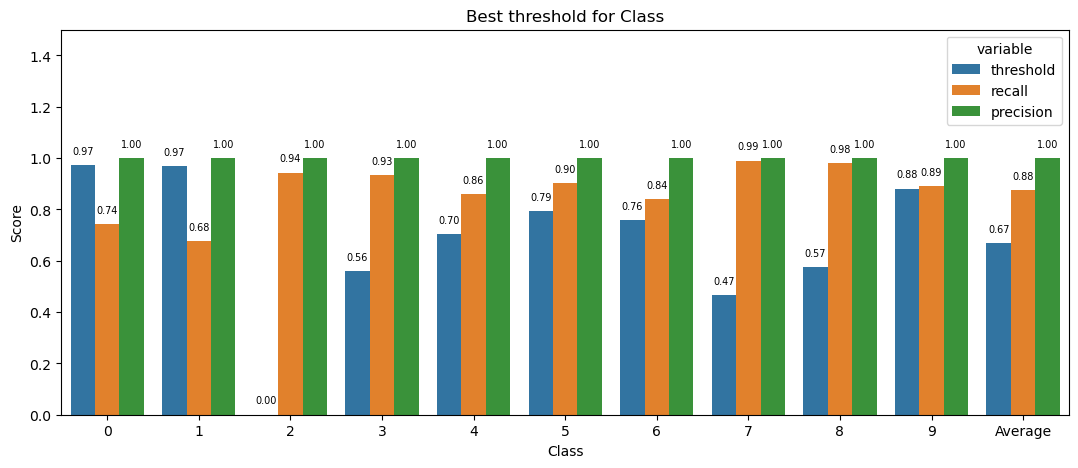

In [16]:
best_threshold_df, plt = overall_test.find_best_threshold()

In [17]:
a = pd.read_excel('./overall_test/test0/best_threshold.xlsx', index_col=0)